# Addition experiment

An implementation of sequence to sequence learning for performing addition

* Input: "535+61"

* Output: "596"

Padding is handled by using a repeated sentinel character (space)
Input may optionally be inverted, shown to increase performance in many tasks in:
"Learning to Execute"
http://arxiv.org/abs/1410.4615
and
"Sequence to Sequence Learning with Neural Networks"
http://papers.nips.cc/paper/5346-sequence-to-sequence-learning-with-neural-networks.pdf
Theoretically it introduces shorter term dependencies between source and target.
Two digits inverted:
+ One layer LSTM (128 HN), 5k training examples = 99% train/test accuracy in 55 epochs
Three digits inverted:
+ One layer LSTM (128 HN), 50k training examples = 99% train/test accuracy in 100 epochs
Four digits inverted:
+ One layer LSTM (128 HN), 400k training examples = 99% train/test accuracy in 20 epochs
Five digits inverted:
+ One layer LSTM (128 HN), 550k training examples = 99% train/test accuracy in 30 epochs

In [1]:
import numpy as np
import tqdm
import theano
import theano.tensor as T
import lasagne
from lasagne.layers import *

import matplotlib.pyplot as plt
%matplotlib inline

## Utils

## Parameters

In [2]:
# Parameters for the model and dataset.
TRAINING_SIZE = 50000
DIGITS = 3
INVERT = True

In [3]:
# Try replacing GRU, or SimpleRNN.
HIDDEN_SIZE = 128
BATCH_SIZE = 128
LAYERS = 1

## Generating data

In [5]:
source_seqs = []
target_seqs = []
seen = set()
print('Generating data...')
while len(source_seqs) < TRAINING_SIZE:
    f = lambda: int(''.join(np.random.choice(list('0123456789'))
                    for i in range(np.random.randint(1, DIGITS + 1))))
    a, b = f(), f()
    # Skip any addition questions we've already seen
    # Also skip any such that x+Y == Y+x (hence the sorting).
    key = tuple(sorted((a, b)))
    if key in seen:
        continue
    seen.add(key)
    # Pad the data with spaces such that it is always MAXLEN.
    q = '{}+{}'.format(a, b)
    ans = str(a + b)
    
    source_seqs.append(q)
    target_seqs.append(["START"] + list(ans) + ["END"])
    
print('Total addition questions:', len(source_seqs))

Generating data...
('Total addition questions:', 50000)


In [6]:
for source, target in zip(source_seqs[:5],target_seqs[:5]):
    print( source,':',"".join(target[1:-1]))

('4+953', ':', '957')
('610+6', ':', '616')
('8+8', ':', '16')
('51+4', ':', '55')
('823+4', ':', '827')


In [7]:
target_letters = list(set([token for ts in target_seqs for token in ts]))
target_letter_to_ix = {ph:i for i,ph in enumerate(target_letters)}

In [8]:
source_letters = list(set([token for word in source_seqs for token in word]))
source_letter_to_ix = {l:i for i,l in enumerate(source_letters)}

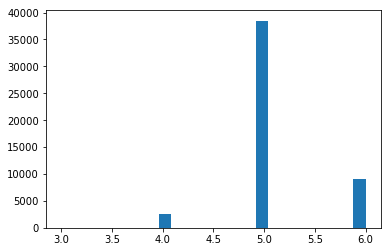

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(list(map(len,target_seqs)),bins=25);

# Truncate names longer than MAX_LEN characters. This can be changed
MAX_LEN = min([150,max(list(map(len, target_seqs)))])

## Cast everything from symbols into matrix of int32. Pad with -1

In [10]:
def as_matrix(sequences, token_to_i, max_len=None, PAX_ix=-1):
    """
    Converts several sequences of tokens to a matrix, edible a neural network.
    Crops at max_len(if given), pads shorter sequences with -1 or PAD_ix.
    """
    max_len = max_len or max(map(len,sequences))
    
    matrix = np.zeros((len(sequences),max_len),dtype='int8') -1
    for i,seq in enumerate(sequences):
        
        row_ix = [token_to_i.get(_, 0) for _ in seq[:max_len]]
        matrix[i,:len(row_ix)] = row_ix
    
    return matrix


## Input vars

In [11]:
input_sequence = T.matrix('token sequence', 'int32')
output_sequence = T.matrix('target target_letters', 'int32')

In [12]:
def non_trainable(net):
    for tags in net.params.itervalues():
        tags -= {'trainable', 'regularizable'}
    return net

In [13]:

##ENCODER
l_in = InputLayer(shape=(None, None),input_var=input_sequence)
l_mask = InputLayer(shape=(None, None),input_var=T.neq(input_sequence,-1)) 


l_emb = non_trainable(EmbeddingLayer(l_in, len(source_letters),  len(source_letters), W=np.diag(np.ones(len(source_letters)))))
l_rnn = LSTMLayer(l_emb, HIDDEN_SIZE, only_return_final=True, mask_input=l_mask)


In [14]:
##DECODER
dec_in = InputLayer(shape=(None, None),input_var=output_sequence)
dec_mask = InputLayer(shape=(None, None),input_var=T.neq(output_sequence,-1))

dec_emb = non_trainable(EmbeddingLayer(dec_in, len(target_letters), len(target_letters), W=np.diag(np.ones(len(target_letters)))))
dec_rnn = LSTMLayer(dec_emb, num_units=HIDDEN_SIZE, cell_init=l_rnn, mask_input=dec_mask)
# WARNING! if it's lstm use cell_init, not hid_init


#flatten batch and time to be compatible with feedforward layers (will un-flatten later)
dec_rnn_flat = reshape(dec_rnn, (-1,dec_rnn.output_shape[-1]))

l_out = DenseLayer(dec_rnn_flat, len(target_letters), nonlinearity=lasagne.nonlinearities.softmax)


In [15]:
# Model weights
weights = get_all_params(l_out)
#print weights

In [16]:
network_output = get_output(l_out)
network_output = network_output.reshape([output_sequence.shape[0],\
                                         output_sequence.shape[1], -1])
#If you use dropout do not forget to create deterministic version for evaluation

In [17]:
predictions_flat = network_output[:,:-1,:].reshape([-1,len(target_letters)])
targets = output_sequence[:,1:].ravel()

#do not count loss for '-1' tokens
mask = T.nonzero(T.neq(targets,-1))

loss = lasagne.objectives.categorical_crossentropy(predictions_flat[mask], targets[mask]).mean()
updates = lasagne.updates.adam(loss,weights)

## Compiling it

In [18]:
#training
train = theano.function([input_sequence, output_sequence], loss, updates=updates, allow_input_downcast=True)

#computing loss without training
compute_cost = theano.function([input_sequence, output_sequence], loss, allow_input_downcast=True)

# Generation

We now need to implement a function that generates output sequence given input.

Such function must work thusly:
```
Init:
x = input
y = ["START"]

While not_too_long:
  p(y_next|x,y) = probabilities of next letter for y
  
  y_next ~ p(y_next|x,y)
  
  y.append(y_next)
  
  if y_next == "END":
      break
```

In [19]:
#compile the function that computes probabilities for next token given previous text.

last_probas =network_output[:, -1]

probs = theano.function([input_sequence, output_sequence], last_probas)

In [20]:
def generate_output(input,
                    output_prefix = ("START",),
                    END_token="END",
                    temperature=1,
                    sample=True):
    
    """
    Implement a function that generates output sequence given input.
    
    We recommend (but not require) you to use the pseudo-code above and inline instructions.
    """
    x = as_matrix([input], source_letter_to_ix) 
    output = list(output_prefix)
    while True:
        y = as_matrix([output], target_letter_to_ix)
        next_y_probs = probs(x, y)
        next_y_probs = (next_y_probs ** temperature) / (next_y_probs ** temperature).sum()
        if sample:
            next_y = np.random.choice(target_letters, p=next_y_probs[0])
        else:
            next_y = target_letters[next_y_probs[0].argmax()]
        next_y = str(next_y)             
        assert type(next_y) is str, "please return token(string/character), not it's index"
        
        output.append(next_y)

        if next_y==END_token:
            break
            
    return output



## Model training

In [21]:
source_seqs = np.array(source_seqs)
target_seqs = np.array(target_seqs)

In [ ]:
def sample_batch(source_seqs,target_seqs, batch_size):
    """samples a random batch of source and target sequences, batch_size elements"""
    batch_ix = np.random.randint(0,len(source_seqs),size=batch_size)
    source_seqs_batch=as_matrix(source_seqs[batch_ix], source_letter_to_ix) 
    target_seqs_batch=as_matrix(target_seqs[batch_ix], target_letter_to_ix)
    
    return source_seqs_batch,target_seqs_batch

In [ ]:
#total N iterations
n_epochs=100

# how many minibatches are there in the epoch 
batches_per_epoch = 500

#how many training sequences are processed in a single function call
batch_size=BATCH_SIZE


for epoch in range(n_epochs):


    avg_cost = 0;
    
    for _ in range(batches_per_epoch):
        
        x,y = sample_batch(source_seqs,target_seqs,batch_size)
        avg_cost += train(x, y).mean()
        
    print("Epoch {} average loss = {}".format(epoch, avg_cost / batches_per_epoch))
    for i in range(5):
        ind = np.random.randint(len(source_seqs))
        print (source_seqs[ind],':', ''.join(generate_output(source_seqs[ind],sample=True)[1:-1]))



Epoch 0 average loss = 1.69220353855
('248+84', ':', '316')
('62+256', ':', '413')
('7+126', ':', '118')
('155+1', ':', '259')
('976+62', ':', '1165')
Epoch 1 average loss = 1.33267121568
('7+404', ':', '611')
('440+24', ':', '429')
('74+827', ':', '907')
('768+70', ':', '904')
('590+637', ':', '1333')
Epoch 2 average loss = 1.13213952782
('846+363', ':', '1157')
('43+693', ':', '734')
('9+288', ':', '289')
('278+49', ':', '310')
('927+416', ':', '1326')
Epoch 3 average loss = 0.993167940189
('658+37', ':', '690')
('743+3', ':', '738')
('286+628', ':', '964')
('60+424', ':', '489')
('498+3', ':', '501')
Epoch 4 average loss = 0.895050642466
('738+19', ':', '752')
('568+4', ':', '663')
('614+209', ':', '855')
('99+623', ':', '719')
('30+528', ':', '558')
Epoch 5 average loss = 0.819492927735
('542+962', ':', '1466')
('946+55', ':', '989')
('1+136', ':', '143')
('644+56', ':', '702')
('441+569', ':', '1011')
Epoch 6 average loss = 0.761436612451
('72+968', ':', '1037')
('109+855', ':', '